# Time Series Decomposition

This tutorial shows how to decompose AutoGP models into their constituent temporal components, to gain more insight into the learned time series structures.

There are many ways to decompose covariance kernels. We will demonstrate three methods:

- [`AutoGP.decompose`](@ref). This function breaks down a composite kernel into the constituent subkernels in the expression tree.
 
- [`AutoGP.extract_kernel`](@ref). This function extracts a specific primitive kernel from a composite kernel, while discarding the others.

- [`AutoGP.split_kernel_sop`](@ref). This function splits a kernel into a pair of kernels through a sum-of-products interpretation.

In [1]:
import AutoGP

In [2]:
using CSV
using Dates
using DataFrames
using Printf
using PythonPlot
using Statistics

In [3]:
AutoGP.seed!(10)

In [4]:
data = CSV.File("assets/M1266.csv")
M3 = DataFrame(data);
df = M3[:,["ds","y"]];

We next split the data into a training set and test set.

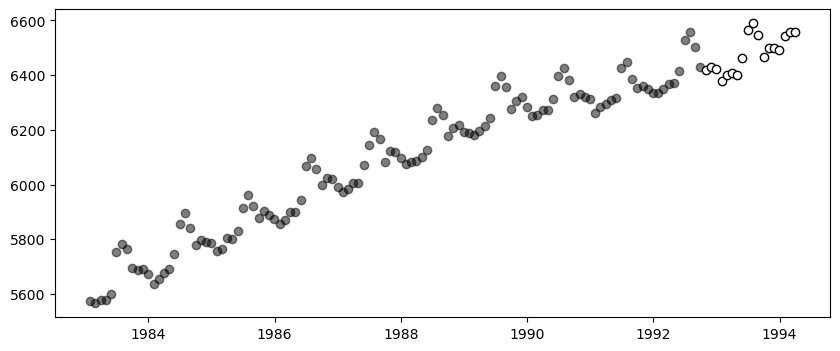

Python: <matplotlib.collections.PathCollection object at 0x7367187bbe30>

In [5]:
n_test = 18
n_train = DataFrames.nrow(df) - n_test
df_train = df[1:end-n_test, :]
df_test = df[end-n_test+1:end, :]

fig, ax = PythonPlot.subplots(figsize=(10,4))
ax.scatter(df_train.ds, df_train.y, marker="o", color="k", alpha=.5)
ax.scatter(df_test.ds, df_test.y, marker="o", color="w", edgecolor="k", label="Test Data")

In [6]:
model = AutoGP.GPModel(df_train.ds, df_train.y; n_particles=18);

In [7]:
ds_future = range(start=df.ds[end]+Dates.Month(1), step=Dates.Month(1), length=4*size(df_test)[1])
ds_query = vcat(df_train.ds, df_test.ds, ds_future)
forecasts = AutoGP.predict(model, ds_query; quantiles=[0.025, 0.975]);

In [8]:
AutoGP.fit_smc!(model; schedule=vcat(collect(range(2, n_train, step=12)), n_train), n_mcmc=100, n_hmc=20, verbose=false);

In [9]:
forecasts = AutoGP.predict(model, ds_query; quantiles=[0.025, 0.975]);

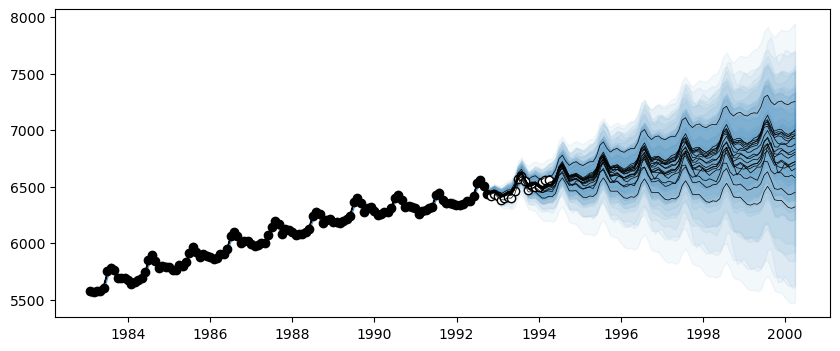

Python: <matplotlib.collections.PathCollection object at 0x7367183731a0>

In [10]:
fig, ax = PythonPlot.subplots(figsize=(10,4))
for i=1:AutoGP.num_particles(model)
    subdf = forecasts[forecasts.particle.==i,:]
    ax.plot(subdf[!,"ds"], subdf[!,"y_mean"], color="k", linewidth=.5)
    ax.fill_between(
        subdf.ds, subdf[!,"y_0.025"], subdf[!,"y_0.975"];
        color="tab:blue", alpha=0.05)
end
ax.scatter(df_train.ds, df_train.y, marker="o", color="k", label="Observed Data")
ax.scatter(df_test.ds, df_test.y, marker="o", color="w", edgecolor="k", label="Test Data")

## Hierarchical Decomposition of Kernels

Let us first inspect the learned kernels.

In [11]:
weights = AutoGP.particle_weights(model)
kernels = AutoGP.covariance_kernels(model)
for (i, (k, w)) in enumerate(zip(kernels, weights))
    println("Model $(i), Weight $(w)")
    display(k)
end

Model 1, Weight 0.00901154857652315


×
├── +
│   ├── LIN(659981029.03; 97715.80, 0.00)
│   └── LIN(1195212711.94; 560685.09, 0.00)
└── +
    ├── +
    │   ├── ×
    │   │   ├── ×
    │   │   │   ├── ×
    │   │   │   │   ├── LIN(645756746.98; 0.12, 0.00)
    │   │   │   │   └── LIN(456367123.42; 0.16, 0.00)
    │   │   │   └── LIN(567802575.74; 0.04, 0.00)
    │   │   └── GE(74314112.16, 1.31; 0.38)
    │   └── PER(1.74, 31698075.82; 0.14)
    └── LIN(435409162.25; 0.10, 0.00)


Model 2, Weight 0.019612029584188975


×
├── LIN(553528205.92; 193073.36, 0.00)
└── +
    ├── GE(610350376.93, 1.32; 0.44)
    └── PER(1.48, 31339381.01; 0.17)


Model 3, Weight 0.017007994352312553


+
├── ×
│   ├── ×
│   │   ├── LIN(466187204.31; 254341.57, 0.00)
│   │   └── LIN(883086760.04; 0.22, 0.00)
│   └── +
│       ├── +
│       │   ├── ×
│       │   │   ├── GE(72266269.78, 1.63; 0.14)
│       │   │   └── LIN(444058228.24; 0.06, 0.00)
│       │   └── +
│       │       ├── LIN(724687893.47; 0.08, 0.00)
│       │       └── LIN(560627320.97; 0.75, 0.00)
│       └── PER(1.09, 31585406.18; 0.13)
└── LIN(558190191.81; 4095788.70, 0.00)


Model 4, Weight 0.11069109354255227


+
├── +
│   ├── GE(566952789.69, 1.66; 53807.36)
│   └── PER(1.86, 31493709.45; 126071.89)
└── LIN(506782708.52; 24208.61, 0.00)


Model 5, Weight 0.015355520708968496


+
├── ×
│   ├── ×
│   │   ├── LIN(703521266.93; 402680.15, 0.00)
│   │   └── LIN(474054605.17; 0.29, 0.00)
│   └── +
│       ├── ×
│       │   ├── LIN(477789221.18; 0.08, 0.00)
│       │   └── +
│       │       ├── GE(93852771.12, 0.56; 0.04)
│       │       └── LIN(445472740.93; 0.11, 0.00)
│       └── PER(1.43, 31593348.89; 0.18)
└── LIN(559007522.80; 27079.33, 0.00)


Model 6, Weight 0.02878043770753873


+
├── ×
│   ├── ×
│   │   ├── LIN(455085567.29; 199889.05, 0.00)
│   │   └── LIN(905419786.45; 0.23, 0.00)
│   └── +
│       ├── ×
│       │   ├── LIN(640199044.16; 0.06, 0.00)
│       │   └── GE(100589877.05, 1.25; 0.18)
│       └── PER(1.43, 31593348.89; 0.18)
└── LIN(593954212.76; 301975.24, 0.00)


Model 7, Weight 0.014477329933002096


+
├── ×
│   ├── +
│   │   ├── LIN(497587817.58; 639968.07, 0.00)
│   │   └── LIN(471057791.81; 1253031.98, 0.00)
│   └── +
│       ├── +
│       │   ├── ×
│       │   │   ├── ×
│       │   │   │   ├── ×
│       │   │   │   │   ├── LIN(458436935.16; 0.16, 0.00)
│       │   │   │   │   └── +
│       │   │   │   │       ├── LIN(610953981.25; 0.16, 0.00)
│       │   │   │   │       └── ×
│       │   │   │   │           ├── ×
│       │   │   │   │           │   ├── LIN(478408274.62; 0.04, 0.00)
│       │   │   │   │           │   └── +
│       │   │   │   │           │       ├── LIN(574886530.87; 0.32, 0.00)
│       │   │   │   │           │       └── LIN(460056017.66; 0.30, 0.00)
│       │   │   │   │           └── ×
│       │   │   │   │               ├── +
│       │   │   │   │               │   ├── +
│       │   │   │   │               │   │   ├── LIN(667199694.27; 0.39, 0.00)
│       │   │   │   │               │   │   └── ×
│       │   │   │   │               │   │       ├── GE(436548

Model 8, Weight 0.047447926279920595


+
├── +
│   ├── GE(490829705.72, 1.61; 53891.92)
│   └── PER(1.86, 31474242.59; 140799.04)
└── +
    ├── +
    │   ├── LIN(719928809.88; 140065.50, 0.00)
    │   └── LIN(450286397.01; 73853.58, 0.00)
    └── LIN(425778979.01; 283629.75, 0.00)


Model 9, Weight 0.010109195479711725


×
├── LIN(510605573.28; 538468.10, 0.00)
└── +
    ├── ×
    │   ├── +
    │   │   ├── ×
    │   │   │   ├── ×
    │   │   │   │   ├── GE(73592603.05, 1.32; 0.30)
    │   │   │   │   └── GE(435853766.92, 0.97; 0.18)
    │   │   │   └── LIN(578736277.07; 0.10, 0.00)
    │   │   └── LIN(485369591.57; 0.50, 0.00)
    │   └── LIN(571286497.84; 0.34, 0.00)
    └── +
        ├── LIN(472756425.93; 0.15, 0.00)
        └── PER(1.29, 31481465.66; 0.16)


Model 10, Weight 0.00019137991483466764


×
├── LIN(568090873.20; 139939.21, 0.00)
└── +
    ├── ×
    │   ├── GE(817646585.97, 1.40; 0.50)
    │   └── +
    │       ├── LIN(444799222.44; 0.03, 0.00)
    │       └── LIN(450268972.65; 0.28, 0.00)
    └── PER(1.24, 31953635.36; 0.17)


Model 11, Weight 0.0054314969855522


+
├── ×
│   ├── ×
│   │   ├── LIN(568363450.73; 442906.88, 0.00)
│   │   └── LIN(478193065.57; 0.35, 0.00)
│   └── +
│       ├── GE(129762049.27, 1.64; 0.07)
│       └── PER(1.42, 31677669.77; 0.25)
└── LIN(479392279.90; 35663.69, 0.00)


Model 12, Weight 0.0076299623510348


+
├── ×
│   ├── LIN(794821416.44; 95231.27, 0.00)
│   └── +
│       ├── GE(212766080.39, 1.53; 0.08)
│       └── PER(1.28, 31642882.88; 0.21)
└── ×
    ├── LIN(1501215005.41; 111622.20, 0.00)
    └── LIN(551494152.52; 0.15, 0.00)


Model 13, Weight 0.3270158643889261


+
├── +
│   ├── GE(308405091.32, 1.55; 46032.60)
│   └── PER(1.86, 31474242.59; 140799.04)
└── LIN(478990944.11; 87109.72, 0.00)


Model 14, Weight 0.08141232858111867


+
├── ×
│   ├── LIN(468516482.12; 1517671.74, 0.00)
│   └── +
│       ├── ×
│       │   ├── ×
│       │   │   ├── ×
│       │   │   │   ├── LIN(458383824.50; 0.08, 0.00)
│       │   │   │   └── LIN(490260027.05; 0.05, 0.00)
│       │   │   └── GE(490829705.72, 1.61; 0.05)
│       │   └── GE(67306478.43, 1.19; 0.35)
│       └── PER(1.86, 31474242.59; 0.14)
└── LIN(611309629.23; 173952.01, 0.00)


Model 15, Weight 0.0005021571370656624


+
├── +
│   ├── ×
│   │   ├── LIN(609809419.35; 610124.73, 0.00)
│   │   └── +
│   │       ├── +
│   │       │   ├── ×
│   │       │   │   ├── ×
│   │       │   │   │   ├── GE(78117685.74, 1.58; 0.04)
│   │       │   │   │   └── LIN(617136973.20; 0.35, 0.00)
│   │       │   │   └── LIN(556041942.24; 0.27, 0.00)
│   │       │   └── LIN(1202344796.78; 0.20, 0.00)
│   │       └── PER(1.91, 31684257.18; 0.22)
│   └── LIN(424034379.19; 103118.46, 0.00)
└── LIN(468608844.61; 212589.52, 0.00)


Model 16, Weight 0.2575040599217603


+
├── +
│   ├── GE(490829705.72, 1.61; 53891.92)
│   └── PER(1.86, 31474242.59; 140799.04)
└── LIN(527880879.77; 307350.63, 0.00)


Model 17, Weight 0.027518336753961727


×
├── LIN(468175029.06; 113767.87, 0.00)
└── +
    ├── +
    │   ├── LIN(525326031.11; 0.19, 0.00)
    │   └── GE(320816202.09, 1.73; 0.99)
    └── +
        ├── LIN(556245068.01; 0.17, 0.00)
        └── PER(1.40, 31519222.30; 0.21)


Model 18, Weight 0.020301337801024034


+
├── GE(361385655.65, 1.74; 365081.64)
└── PER(1.30, 31583405.26; 131132.44)


We now use [`AutoGP.decompose`](@ref) to hierarchically break down the composite kernel into all the constituent subkernels.

In [12]:
decomposed_models = AutoGP.decompose(model);

In [13]:
# Helper function to pretty print covariance.
function show_string(x)
    io = IOBuffer()
    Base.show(io, MIME("text/plain"), x)
    return String(take!(io))
end

# Plot the decomposition of `model` into its constituent parts.
function plot_decomposition(model::AutoGP.GPModel)
    kernels = AutoGP.covariance_kernels(model)
    forecasts = AutoGP.predict(
        model, ds_query;
        quantiles=[0.025, 0.975]);
    fig, axes = PythonPlot.subplots(
        nrows=AutoGP.num_particles(model),
        ncols=2,
        tight_layout=true,
        figsize=(12, 6*AutoGP.num_particles(model)),
        )
    for i=1:AutoGP.num_particles(model)
        subdf = forecasts[forecasts.particle.==i,:]
        # axes[i].set_title(show_string(kernels[i]), ha="left")
        axes[i-1,0].plot(subdf[!,"ds"], subdf[!,"y_mean"], color="k", linewidth=1, label=show_string(kernels[i]))
        axes[i-1,0].fill_between(
            subdf.ds, subdf[!,"y_0.025"], subdf[!,"y_0.975"];
            color="tab:blue", alpha=0.05)
        axes[i-1,0].scatter(df_train.ds, df_train.y, marker="o", color="k", label="Observed Data")
        axes[i-1,0].scatter(df_test.ds, df_test.y, marker="o", color="w", edgecolor="k", label="Test Data")
        axes[i-1,1].text(0.5, 0.5, show_string(kernels[i]), transform=axes[i-1,1].transAxes,  va="center", ha="left")
        axes[i-1,1].set_axis_off()
    end
    return fig, axes
end

plot_decomposition (generic function with 1 method)

Let us plot the decomposition of a given particle in the ensemble.

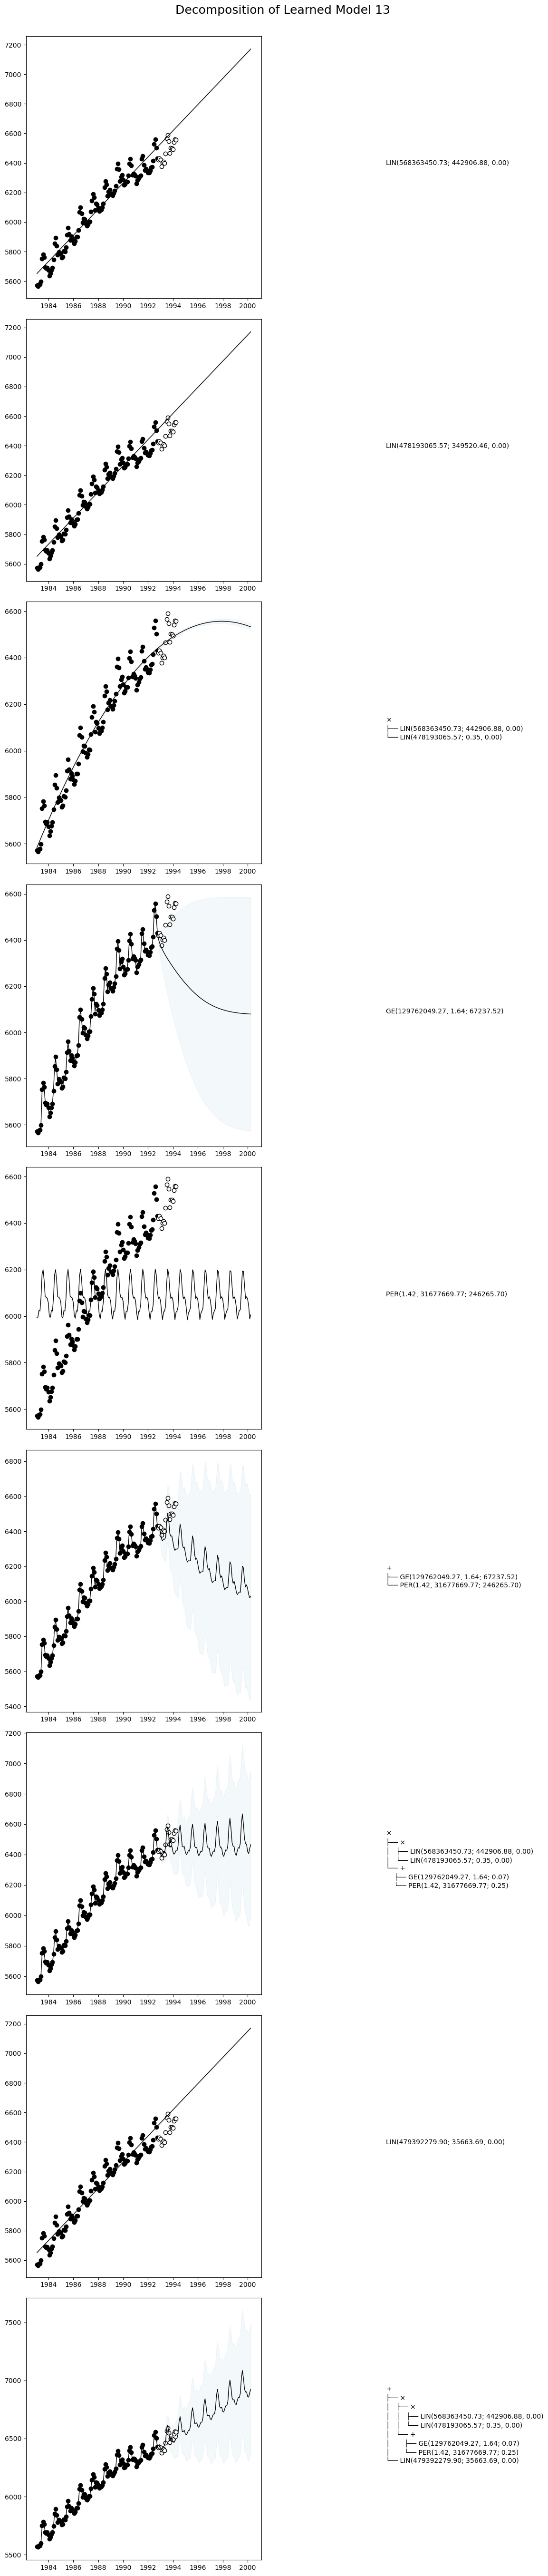

In [14]:
idx = 13
fig, ax = plot_decomposition(decomposed_models[11]);
fig.suptitle("Decomposition of Learned Model $(idx)", fontsize=18, va="center", y=1);

## STL Style Decomposition

An alternative approach to decomposing kernels is using [`AutoGP.extract_kernel`](@ref), which retains only a specific primitive kernel while discarding the others. In the following example, we will extract the [`AutoGP.GP.Linear`](@ref), [`AutoGP.GP.Periodic`](@ref), and [`AutoGP.GP.GammaExponential`](@ref) kernels from each learned particle to produce an "STL" style decomposition.

In [15]:
model_per = AutoGP.extract_kernel(model, AutoGP.GP.Periodic);
model_ge = AutoGP.extract_kernel(model, AutoGP.GP.GammaExponential);
model_lin = AutoGP.extract_kernel(model, AutoGP.GP.Linear);

Let us study the original and decomposed kernels for a given particle.

Unlike a [traditional time series decomposition](https://en.wikipedia.org/wiki/Decomposition_of_time_series), which typically assumes a fixed additive or multiplicative structure, these decompositions retain the learned structure. For example, the decomposition for `Linear` may have a quadratic term, if the overall kernel has a subexpression of the form `LIN * LIN`.

The kernel structure is retained by using the [`AutoGP.GP.Constant`](@ref) to act as a "noop", as shown below. See also [`AutoGP.extract_kernel`](@ref) for full details.

In [16]:
idx = 2
println("Model $(idx) - FULL"); display(AutoGP.covariance_kernels(model)[2])
println("Model $(idx) - LIN only"); display(AutoGP.covariance_kernels(model_lin)[2])
println("Model $(idx) - PER only"); display(AutoGP.covariance_kernels(model_per)[2])
println("Model $(idx) - GE only"); display(AutoGP.covariance_kernels(model_ge)[2])

Model 2 - FULL


×
├── LIN(553528205.92; 193073.36, 0.00)
└── +
    ├── GE(610350376.93, 1.32; 0.44)
    └── PER(1.48, 31339381.01; 0.17)


Model 2 - LIN only


×
├── LIN(553528205.92; 193073.36, 0.00)
└── +
    ├── CONST(0.00)
    └── CONST(0.00)


Model 2 - PER only


×
├── CONST(985751.12)
└── +
    ├── CONST(0.00)
    └── PER(1.48, 31339381.01; 0.17)


Model 2 - GE only


×
├── CONST(985751.12)
└── +
    ├── GE(610350376.93, 1.32; 0.44)
    └── CONST(0.00)


We can now obtain forecasts corresponding to the Linear, Periodic, and GammaExponential components in each particle.

In [17]:
forecasts_lin = AutoGP.predict(model_lin, ds_query .+ Day(1); quantiles=[0.025, 0.975]);
forecasts_per = AutoGP.predict(model_per, ds_query .+ Day(1); quantiles=[0.025, 0.975]);
forecasts_ge = AutoGP.predict(model_ge, ds_query .+ Day(1); quantiles=[0.025, 0.975]);

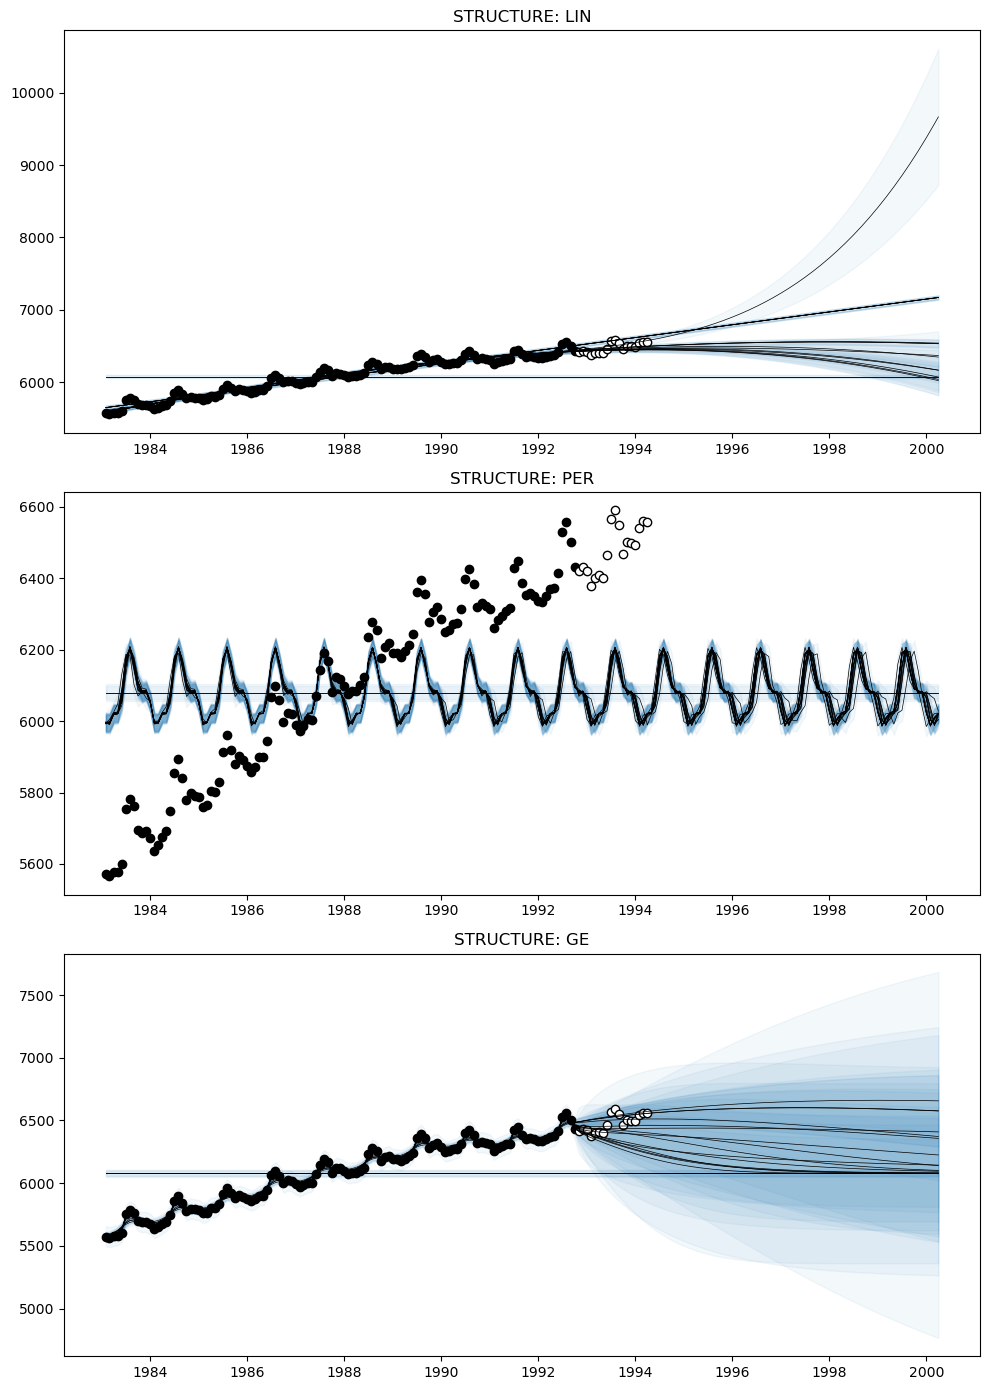

Python: Text(0.5, 1.0, 'STRUCTURE: GE')

In [18]:
fig, axes = PythonPlot.subplots(figsize=(10,14), nrows=3, tight_layout=true)
for (ax, m, f) in zip(axes, [model_lin, model_per, model_ge], [forecasts_lin, forecasts_per, forecasts_ge])
    for i=1:AutoGP.num_particles(m)
        subdf = f[f.particle.==i,:]
        ax.plot(subdf[!,"ds"], subdf[!,"y_mean"], color="k", linewidth=.5)
        ax.fill_between(subdf.ds, subdf[!,"y_0.025"], subdf[!,"y_0.975"]; color="tab:blue", alpha=0.05)
    end
    ax.scatter(df_train.ds, df_train.y, marker="o", color="k", label="Observed Data")
    ax.scatter(df_test.ds, df_test.y, marker="o", color="w", edgecolor="k", label="Test Data")
end
axes[0].set_title("STRUCTURE: LIN")
axes[1].set_title("STRUCTURE: PER")
axes[2].set_title("STRUCTURE: GE")

## Sum-of-Products Decomposition

An third approach to decomposing kernels is using [`AutoGP.split_kernel_sop`](@ref), which is based on a sum-of-products decomposition of kernels.

In particular, we can write any composite covariance kernel $k$ as a sum of $m$ products, where the $i$th term in the sum is a product of $n_i$ terms:

```math
k = k_{11}k_{12}\cdots k_{1n_1} + k_{21}k_{22}\cdots k_{2n_2} + \dots + k_{m1}k_{m2}\cdots k_{m n_m}.
```

For a given primitive base kernel, such as `Periodic`, we can rewrite the above expression as

```math
k = k^{\rm PER} + k^{\rm NOPER},
```

where $k^{\rm PER}$ contains all addends with a `Periodic` factor, and $k^{\rm NOPER}$ are the addends without a `Periodic` factor.

See [`AutoGP.GP.split_kernel_sop`](@ref) for additional details.

The following function returns a pair of [`AutoGP.GPModel`](@ref) instances based on this decomposition.

In [19]:
model_a, model_b = AutoGP.split_kernel_sop(model, AutoGP.GP.Periodic);

Here is an example of the decomposition on the 4th particle of `model`.

In [20]:
idx = 4
println("Model $(idx) - ALL"); display(AutoGP.covariance_kernels(model)[idx])
println("Model $(idx) - PER"); display(AutoGP.covariance_kernels(model_a)[idx])
println("Model $(idx) - NO PER"); display(AutoGP.covariance_kernels(model_b)[idx])

Model 4 - ALL


+
├── +
│   ├── GE(566952789.69, 1.66; 53807.36)
│   └── PER(1.86, 31493709.45; 126071.89)
└── LIN(506782708.52; 24208.61, 0.00)


Model 4 - PER


PER(1.86, 31493709.45; 126071.89)


Model 4 - NO PER


+
├── GE(566952789.69, 1.66; 53807.36)
└── LIN(506782708.52; 24208.61, 0.00)


We can obtain predictions from the sum-of-products using [`AutoGP.GP.predict_sum`](@ref).

In [21]:
forecasts_sum = AutoGP.predict_sum(model, ds_query, AutoGP.GP.Periodic; quantiles=[0.025, 0.975]);

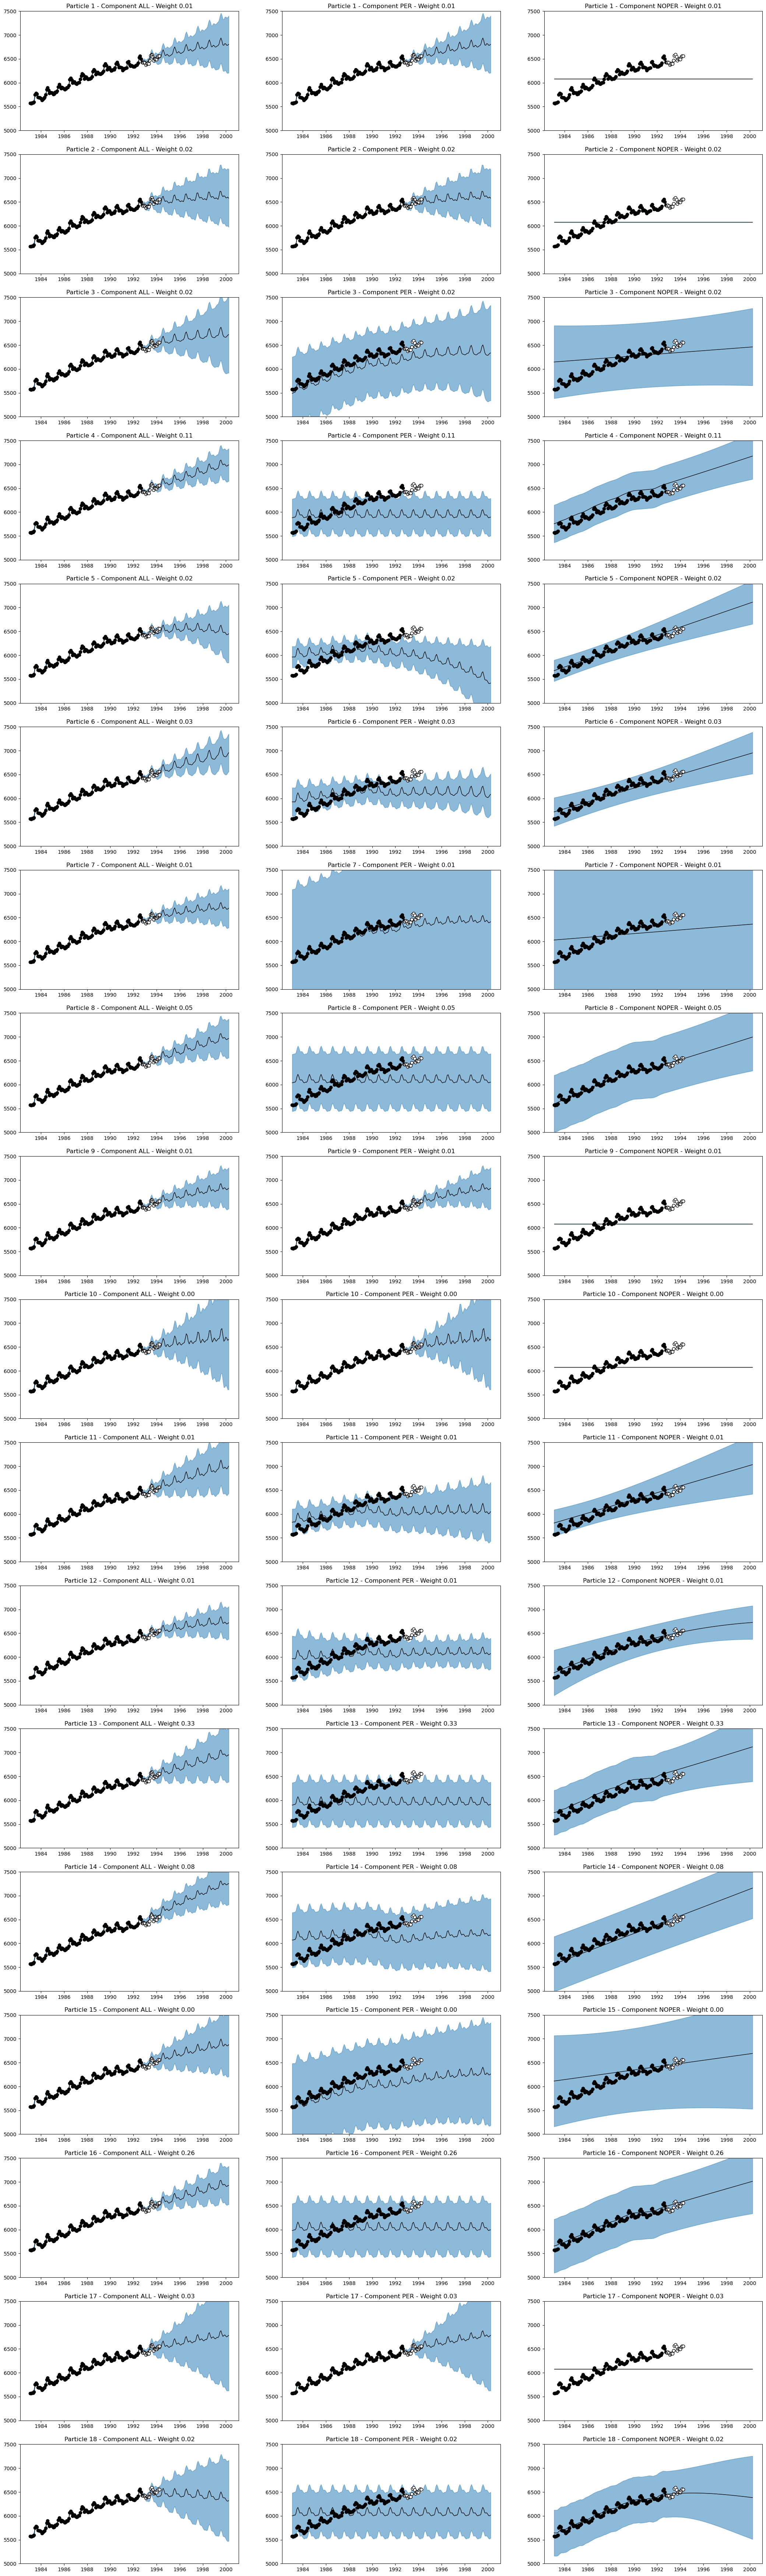

Python: None

In [22]:
title = ["ALL", "PER", "NOPER"]
nrows = AutoGP.num_particles(model)
fig, axes = PythonPlot.subplots(ncols=3, nrows=nrows, figsize=(26,5*nrows))
for particle=1:AutoGP.num_particles(model)
    f = forecasts_sum[forecasts_sum.particle .== particle,:]
    for (component, ax) in zip(0:2, axes[particle-1])
        subdf = f[f.component .== component,:]
        ax.plot(subdf[!,"ds"], subdf[!,"y_mean"], color="k", linewidth=1)
        ax.fill_between(subdf.ds, subdf[!,"y_0.025"], subdf[!,"y_0.975"]; color="tab:blue", alpha=0.5)
        ax.scatter(df_train.ds, df_train.y, marker="o", color="k", label="Observed Data")
        ax.scatter(df_test.ds, df_test.y, marker="o", color="w", edgecolor="k", label="Test Data")
        w = @sprintf("%1.2f", maximum(subdf.weight))
        ax.set_title("Particle $(particle) - Component $(title[component+1]) - Weight $(w)")
        ax.set_ylim([5000, 7500])
    end
end
fig.savefig("forecasts-joint.png", dpi=150)

Using [`AutoGP.GP.predict_mvn_sum`](@ref) gives the overall mixture of Gaussians.

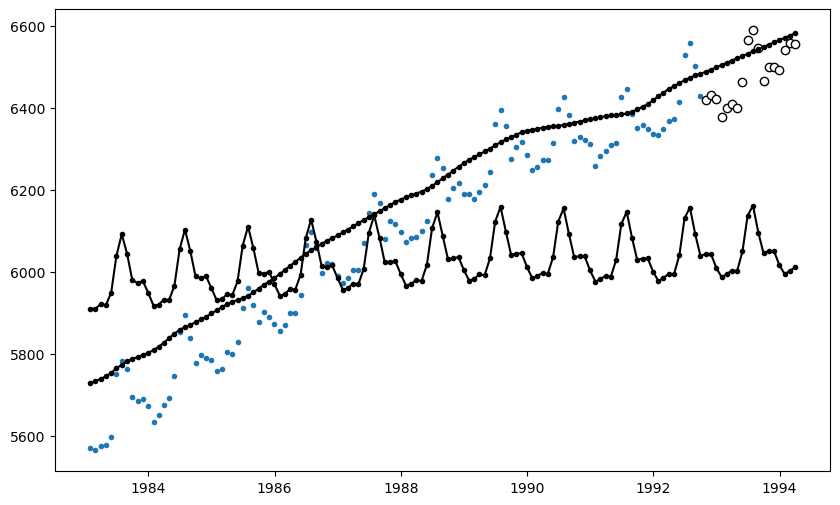

Python: <matplotlib.collections.PathCollection object at 0x73660308d5b0>

In [23]:
ds_probe = vcat(df_train.ds, df_test.ds)
mvn, indexes = AutoGP.predict_mvn_sum(model, ds_probe, AutoGP.GP.Periodic);

overall_predictions = mean(mvn)[indexes.Y]
seasonal_predictions = mean(mvn)[indexes.F[1]]
nonseasonal_predictions = mean(mvn)[indexes.F[2]]
fig, ax = PythonPlot.subplots(figsize=(10,6))
ax.plot(ds_probe, seasonal_predictions, marker=".", color="k")
ax.plot(ds_probe, nonseasonal_predictions, marker=".", color="k")
ax.scatter(df_train.ds, df_train.y, marker=".")
ax.scatter(df_test.ds, df_test.y, marker="o", edgecolor="k", facecolor="w")